# Real Life Example: Classifying Speed Limit Signs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.6')

Using TensorFlow backend.


2.0.8


## Loading and Preparing Data

In [8]:
!ls -l speed-limit-signs

total 28
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 0
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 1
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 2
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 3
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 4
drwxrwxr-x 2 ubuntu ubuntu 4096 Sep 27 15:25 5
-rw-rw-r-- 1 ubuntu ubuntu  380 Oct  1 08:09 README.md


In [9]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [10]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [11]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [12]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

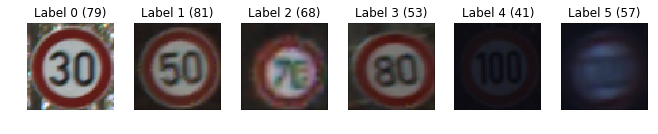

In [13]:
display_images_and_labels(images, labels)

In [14]:
# again a little bit of feature engeneering

y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

## Let's start with creating a minimal model that overfits on a very small training set
http://cs231n.github.io/neural-networks-3/#sanitycheck

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [16]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

## This is how overfitting looks like in the Metrics
### Accuracy
![Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc-overfitting.png "Accuracy Overfitting")
### Validation Accuracy
![Validation Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc-overfitting.png "Validation Accuracy Overfitting")

In [17]:
# full architecture
# %load https://djcordhose.github.io/ai/fragments/vgg_style_no_dropout.py

# my sample minimized architecture
# %load https://djcordhose.github.io/ai/fragments/vgg_style_no_dropout_overfitting.py

In [18]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                262208    
__________

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Determines how many samples are using for training in one batch
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 500

In [21]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=BATCH_SIZE)

Train on 29 samples, validate on 8 samples
Epoch 1/100
29/29 [==============================] - 3s - loss: 1.7860 - acc: 0.1724 - val_loss: 1.7473 - val_acc: 0.1250
Epoch 2/100
29/29 [==============================] - 0s - loss: 1.6542 - acc: 0.2414 - val_loss: 1.8353 - val_acc: 0.1250
Epoch 3/100
29/29 [==============================] - 0s - loss: 1.6456 - acc: 0.2414 - val_loss: 1.7074 - val_acc: 0.1250
Epoch 4/100
29/29 [==============================] - 0s - loss: 1.6047 - acc: 0.2414 - val_loss: 1.6178 - val_acc: 0.2500
Epoch 5/100
29/29 [==============================] - 0s - loss: 1.5856 - acc: 0.3448 - val_loss: 1.6116 - val_acc: 0.2500
Epoch 6/100
29/29 [==============================] - 0s - loss: 1.5599 - acc: 0.3793 - val_loss: 1.6550 - val_acc: 0.2500
Epoch 7/100
29/29 [==============================] - 0s - loss: 1.5202 - acc: 0.3448 - val_loss: 1.7536 - val_acc: 0.1250
Epoch 8/100
29/29 [==============================] - 0s - loss: 1.4941 - acc: 0.2414 - val_loss: 1.8083

29/29 [==============================] - 0s - loss: 0.1280 - acc: 1.0000 - val_loss: 3.4744 - val_acc: 0.3750
Epoch 68/100
29/29 [==============================] - 0s - loss: 0.1220 - acc: 1.0000 - val_loss: 3.5733 - val_acc: 0.3750
Epoch 69/100
29/29 [==============================] - 0s - loss: 0.1157 - acc: 1.0000 - val_loss: 3.6973 - val_acc: 0.3750
Epoch 70/100
29/29 [==============================] - 0s - loss: 0.1100 - acc: 1.0000 - val_loss: 3.8220 - val_acc: 0.3750
Epoch 71/100
29/29 [==============================] - 0s - loss: 0.1044 - acc: 1.0000 - val_loss: 3.9156 - val_acc: 0.3750
Epoch 72/100
29/29 [==============================] - 0s - loss: 0.0993 - acc: 1.0000 - val_loss: 3.9784 - val_acc: 0.3750
Epoch 73/100
29/29 [==============================] - 0s - loss: 0.0943 - acc: 1.0000 - val_loss: 4.0077 - val_acc: 0.3750
Epoch 74/100
29/29 [==============================] - 0s - loss: 0.0897 - acc: 1.0000 - val_loss: 4.0379 - val_acc: 0.2500
Epoch 75/100
29/29 [=========

---

# Hands-On: Create a minimal model


# Step #1: Simplify the given architecture until you can no longer overfit on the small training set
* reduce number of epochs while training to 50 or even less to have quick experinemtation cycles
* reduce number of layers
* reduce number of feature channels
* make sure your modell actualy has less parameters than the original one (was 4,788,358)
* if you need a special challenge you can write your model from scratch (you can always reload the original one using the prepared %load)

---

## Now we see that the model at least has the basic capacity for the task, we have to get rid of the overfitting
## How to avoid Overfitting using Dropouts
* A Dropout Layers blacks out a certain percentage of input neurons
* Which each update of weihts during training other neurons are chosen
* Hope is to train different parts of the network with each iteration avoiding overfitting
* Dropout rate typically between 40% and 75%
* VGG adds Dropout after each convolutional block and after fc layer
  * ```x = Dropout(0.5)(x)```
* this only applies for training phase, in prediction there is no such layer  

---

# Step #2: Train on the complete training set and make sure to still avoid overfitting by optimizing for val-acc

* train on the complete training set
* add dropout of 50% as described above
* gradually make your model more complex until you have minimized overfitting
* 90% and more of validation accuracy are possible
* again, reduce the number of epochs of your model to make it trainable on your hardware (100 might work well)
* if it does not show signs of converging early on, it is likely not complex enough
* you can also start with a pre-defined architecture and make this less compelx (again using the prepared %load)
* save the trained model for later comparison

---

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [24]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [25]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [26]:
keras.layers.Dropout?

In [27]:
# full architecture with dropout
# %load https://djcordhose.github.io/ai/fragments/vgg_style_dropout.py

# my sample minimized architecture
# %load https://djcordhose.github.io/ai/fragments/vgg_style_dropout_minmal.py

In [28]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
__________

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
!rm -r tf_log

In [31]:
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 242 samples, validate on 61 samples
Epoch 1/500
242/242 [==============================] - 2s - loss: 1.7566 - acc: 0.2314 - val_loss: 1.8777 - val_acc: 0.0984
Epoch 2/500
242/242 [==============================] - 0s - loss: 2.7072 - acc: 0.2273 - val_loss: 1.6280 - val_acc: 0.2787
Epoch 3/500
242/242 [==============================] - 0s - loss: 2.4442 - acc: 0.2025 - val_loss: 1.7096 - val_acc: 0.3279
Epoch 4/500
242/242 [==============================] - 0s - loss: 1.9441 - acc: 0.1818 - val_loss: 1.7659 - val_acc: 0.2787
Epoch 5/500
242/242 [==============================] - 0s - loss: 1.8391 - acc: 0.1860 - val_loss: 1.7847 - val_acc: 0.2787
Epoch 6/500
242/242 [==============================] - 0s - loss: 1.8113 - acc: 0.1653 - val_loss: 1.7901 - val_acc: 0.2787
Epoch 7/500
242/242 [==============================] - 0s - loss: 1.7910 - acc: 0.1653 - val_loss: 1.7914 - val_acc: 0.2623
Epoch 8/500
242/242 [==============================] - 0s - loss: 1.7854 - acc: 0.2107 

242/242 [==============================] - 0s - loss: 1.3866 - acc: 0.4298 - val_loss: 1.5092 - val_acc: 0.4098
Epoch 67/500
242/242 [==============================] - 0s - loss: 1.3544 - acc: 0.4463 - val_loss: 1.5112 - val_acc: 0.3607
Epoch 68/500
242/242 [==============================] - 0s - loss: 1.3426 - acc: 0.4587 - val_loss: 1.5094 - val_acc: 0.4262
Epoch 69/500
242/242 [==============================] - 0s - loss: 1.3628 - acc: 0.4380 - val_loss: 1.5145 - val_acc: 0.4098
Epoch 70/500
242/242 [==============================] - 0s - loss: 1.3330 - acc: 0.4711 - val_loss: 1.5027 - val_acc: 0.3934
Epoch 71/500
242/242 [==============================] - 0s - loss: 1.3339 - acc: 0.4050 - val_loss: 1.4998 - val_acc: 0.4262
Epoch 72/500
242/242 [==============================] - 0s - loss: 1.2524 - acc: 0.5000 - val_loss: 1.4846 - val_acc: 0.3934
Epoch 73/500
242/242 [==============================] - 0s - loss: 1.2782 - acc: 0.4876 - val_loss: 1.4499 - val_acc: 0.4426
Epoch 74/500


242/242 [==============================] - 0s - loss: 0.3070 - acc: 0.9008 - val_loss: 0.5437 - val_acc: 0.8689
Epoch 132/500
242/242 [==============================] - 0s - loss: 0.3111 - acc: 0.9256 - val_loss: 0.6165 - val_acc: 0.8689
Epoch 133/500
242/242 [==============================] - 0s - loss: 0.3036 - acc: 0.9008 - val_loss: 0.6290 - val_acc: 0.8525
Epoch 134/500
242/242 [==============================] - 0s - loss: 0.2760 - acc: 0.9215 - val_loss: 0.5637 - val_acc: 0.8689
Epoch 135/500
242/242 [==============================] - 0s - loss: 0.3009 - acc: 0.9132 - val_loss: 0.4879 - val_acc: 0.8689
Epoch 136/500
242/242 [==============================] - 0s - loss: 0.2640 - acc: 0.9132 - val_loss: 0.4396 - val_acc: 0.8852
Epoch 137/500
242/242 [==============================] - 0s - loss: 0.2461 - acc: 0.9091 - val_loss: 0.4379 - val_acc: 0.8852
Epoch 138/500
242/242 [==============================] - 0s - loss: 0.1995 - acc: 0.9339 - val_loss: 0.4471 - val_acc: 0.8852
Epoch 

242/242 [==============================] - 0s - loss: 0.0743 - acc: 0.9752 - val_loss: 0.2871 - val_acc: 0.9016
Epoch 197/500
242/242 [==============================] - 0s - loss: 0.0661 - acc: 0.9752 - val_loss: 0.2832 - val_acc: 0.8689
Epoch 198/500
242/242 [==============================] - 0s - loss: 0.0863 - acc: 0.9669 - val_loss: 0.2641 - val_acc: 0.9344
Epoch 199/500
242/242 [==============================] - 0s - loss: 0.0902 - acc: 0.9793 - val_loss: 0.2629 - val_acc: 0.9180
Epoch 200/500
242/242 [==============================] - 0s - loss: 0.0875 - acc: 0.9711 - val_loss: 0.2774 - val_acc: 0.9344
Epoch 201/500
242/242 [==============================] - 0s - loss: 0.0739 - acc: 0.9711 - val_loss: 0.2884 - val_acc: 0.9180
Epoch 202/500
242/242 [==============================] - 0s - loss: 0.0787 - acc: 0.9711 - val_loss: 0.2913 - val_acc: 0.8852
Epoch 203/500
242/242 [==============================] - 0s - loss: 0.0452 - acc: 0.9959 - val_loss: 0.3097 - val_acc: 0.8852
Epoch 

242/242 [==============================] - 0s - loss: 0.0348 - acc: 0.9917 - val_loss: 0.3198 - val_acc: 0.9016
Epoch 262/500
242/242 [==============================] - 0s - loss: 0.0385 - acc: 0.9917 - val_loss: 0.3173 - val_acc: 0.8852
Epoch 263/500
242/242 [==============================] - 0s - loss: 0.0377 - acc: 0.9917 - val_loss: 0.2989 - val_acc: 0.8852
Epoch 264/500
242/242 [==============================] - 0s - loss: 0.0382 - acc: 0.9917 - val_loss: 0.2839 - val_acc: 0.8852
Epoch 265/500
242/242 [==============================] - 0s - loss: 0.0320 - acc: 0.9876 - val_loss: 0.2691 - val_acc: 0.8852
Epoch 266/500
242/242 [==============================] - 0s - loss: 0.0390 - acc: 0.9876 - val_loss: 0.2564 - val_acc: 0.9016
Epoch 267/500
242/242 [==============================] - 0s - loss: 0.0222 - acc: 1.0000 - val_loss: 0.2476 - val_acc: 0.9180
Epoch 268/500
242/242 [==============================] - 0s - loss: 0.0425 - acc: 0.9793 - val_loss: 0.2613 - val_acc: 0.9180
Epoch 

242/242 [==============================] - 0s - loss: 0.0228 - acc: 0.9917 - val_loss: 0.3080 - val_acc: 0.9344
Epoch 327/500
242/242 [==============================] - 0s - loss: 0.0497 - acc: 0.9917 - val_loss: 0.3110 - val_acc: 0.9180
Epoch 328/500
242/242 [==============================] - 0s - loss: 0.0211 - acc: 0.9917 - val_loss: 0.3236 - val_acc: 0.9016
Epoch 329/500
242/242 [==============================] - 0s - loss: 0.0106 - acc: 0.9959 - val_loss: 0.3352 - val_acc: 0.9016
Epoch 330/500
242/242 [==============================] - 0s - loss: 0.0266 - acc: 0.9917 - val_loss: 0.3393 - val_acc: 0.9180
Epoch 331/500
242/242 [==============================] - 0s - loss: 0.0150 - acc: 1.0000 - val_loss: 0.3439 - val_acc: 0.9180
Epoch 332/500
242/242 [==============================] - 0s - loss: 0.0141 - acc: 0.9959 - val_loss: 0.3514 - val_acc: 0.9180
Epoch 333/500
242/242 [==============================] - 0s - loss: 0.0212 - acc: 0.9917 - val_loss: 0.3488 - val_acc: 0.9180
Epoch 

242/242 [==============================] - 0s - loss: 0.0151 - acc: 0.9959 - val_loss: 0.3013 - val_acc: 0.9180
Epoch 392/500
242/242 [==============================] - 0s - loss: 0.0165 - acc: 0.9917 - val_loss: 0.3024 - val_acc: 0.9180
Epoch 393/500
242/242 [==============================] - 0s - loss: 0.0148 - acc: 1.0000 - val_loss: 0.3044 - val_acc: 0.9016
Epoch 394/500
242/242 [==============================] - 0s - loss: 0.0342 - acc: 0.9917 - val_loss: 0.2992 - val_acc: 0.9180
Epoch 395/500
242/242 [==============================] - 0s - loss: 0.0162 - acc: 0.9917 - val_loss: 0.3018 - val_acc: 0.9180
Epoch 396/500
242/242 [==============================] - 0s - loss: 0.0242 - acc: 0.9917 - val_loss: 0.3080 - val_acc: 0.9180
Epoch 00395: early stopping
CPU times: user 1min 46s, sys: 18.5 s, total: 2min 4s
Wall time: 2min 59s


In [36]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 0s


(0.066526636481285095, 0.98349833488464355)

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 0s


(0.45080634951591492, 0.89473682641983032)

## How Metrics might look like when training 500 epochs with given full model

Training size makes this a little bit hard to interpret. Might look different for different random split.

### Accuracy
![Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc.png "Accuracy")
### Validation Accuracy
![Validation Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc.png "Validation Accuracy")

In [38]:
# model.save('conv-vgg.hdf5')
model.save('conv-simple.hdf5')

In [39]:
!ls -lh

total 972M
-rw-rw-r-- 1 ubuntu ubuntu  44K Oct  1 08:04 440px-Beagle_Upsy.jpg
drwxrwxr-x 8 ubuntu ubuntu 4.0K Oct  1 08:10 augmented-signs
-rw-rw-r-- 1 ubuntu ubuntu  17M Oct  1 08:10 augmented-signs.zip
-rw-rw-r-- 1 ubuntu ubuntu 303K Sep 27 15:22 Black_New_York_stuy_town_squirrel_amanda_ernlund.jpeg
-rw-rw-r-- 1 ubuntu ubuntu 844K Oct  1 08:04 cat-bonkers.png
-rw-rw-r-- 1 ubuntu ubuntu 140K Oct  1 13:50 cnn-augmentation.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 1.6M Oct  2 13:22 cnn-comparing-all-models.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 136K Oct  2 09:42 cnn-imagenet-retrain.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 158K Oct  2 08:41 cnn-intro.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 107K Oct  2 09:41 cnn-standard-architectures.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 199K Oct  2 07:51 cnn-train-augmented.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 3.1M Oct  2 13:07 conv-minimal.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  26M Oct  2 13:36 conv-simple.hdf5
-rw-rw-r-- 1 ubuntu ubuntu  55M Oct  1 15:13 conv-vgg-augmented.hdf5
-rw-rw-r-- 1 ubu

In [ ]:
# https://transfer.sh/
# Saved for 14 days
# !curl --upload-file conv-vgg.hdf5 https://transfer.sh
!curl --upload-file conv-simple.hdf5 https://transfer.sh

# pre-trained model
# acc: 0.98- val_acc: 0.89
# https://transfer.sh/DuZA7/conv-simple.hdf5

# What images does it work well on?

In [45]:
import random

# Pick 10 random images for test data set
random.seed(42) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [46]:
ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([1, 3, 5, 3, 3, 1, 4, 4, 0, 2])

In [47]:
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 3, 4, 3, 3, 1, 4, 4, 0, 2])

In [48]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

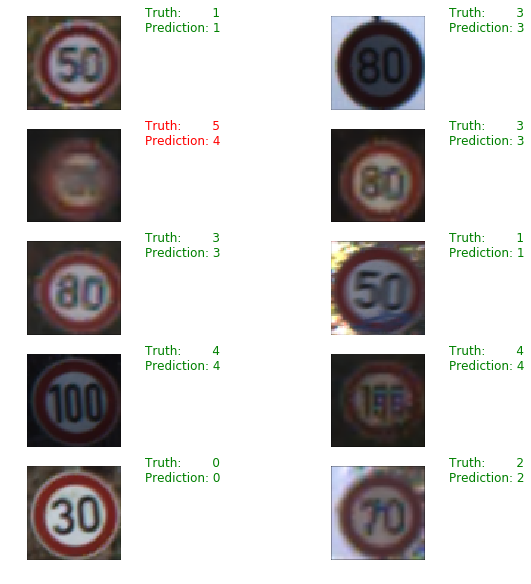

In [49]:
display_prediction(sample_images, ground_truth, predicted_categories)